## Classification

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
patdf = pd.read_csv("Patient_withRUCA_withage.csv")
#patdf.head(3)

In [6]:
'''
Dropping unneccessary columns
'''
print(patdf.columns)
patdf = patdf.drop(columns= ["Unnamed: 0", "MRN", "Address", "City", "Zipcode", "Cancer Diagnosis (ICD-10)",
                             "FIPS", "County", "Census Tract", "DOB"])
#patdf.head()

Index(['Unnamed: 0', 'MRN', 'DOB', 'Age', 'Gender', 'Race/Ethnicity',
       'Address', 'City', 'Zipcode', 'Cancer Diagnosis (ICD-10)', 'Stage',
       'Clinical Trial Participant', 'Tobacco Use', 'Census Tract', 'County',
       'Cancer Description', 'FIPS', 'RUCA'],
      dtype='object')


## Pre-processing for classificaiton

In [7]:
"""
2. Keep rows with only certain cancer diagnoses
1. Drop rows with missing values for RUCA
3. Refine Race/Ethnicity column
"""

#Keep rows with only certain cancer diagnoses
Keep = ["Esophageal cancer", "Gastric cancer", 
        "Colorectal cancer", "Pancreatic cancer","Head and neck cancer",
        "Lung cancer", "Breast cancer", "Prostate cancer",
        "Urothelial/bladder cancer", "Kidney cancer", "Thyroid cancer"]
print("Shape before filtering based on cancers",patdf.shape)
patdf = patdf[patdf["Cancer Description"].isin(Keep)]
print("Shape after filtering based on cancers",patdf.shape)


#Dropping RUCA NaNs
print("Shape before dropping null RUCA", patdf.shape)
patdf = patdf[patdf["RUCA"].notnull()]
print("Shape after dropping null RUCA", patdf.shape)


#Refining Race/Ethnicity Column
patdf["Race/Ethnicity"] = patdf["Race/Ethnicity"].replace(to_replace = 
                                                          ["African American","Other","Asian",
                                                           "Native Hawaiian or Other Pacific Islander",
                                                          "American Indian or Alaskan Native"],
                                                          value="Non-White")

#patdf.head()

Shape before filtering based on cancers (8972, 8)
Shape after filtering based on cancers (5420, 8)
Shape before dropping null RUCA (5420, 8)
Shape after dropping null RUCA (3446, 8)


In [8]:
'''
Discretize age into: [18-40, 40-60, 60-80, 80+]
Compare result with continous age vairable
For now, use continous age.
'''
# def discretizeage(df):
#     agestr = df.loc[index,"DOB"]
#     year = int(agestr.split("/")[2])
#     if (year>=20 and year<=40):
#         df.loc[index,"DOB"] = "80+"
#     elif (year>40 and year<=60):
#         df.loc[index,"DOB"] = "60-80"
#     elif (year>60 and year<=80):
#         df.loc[index,"DOB"] = "40-60"
#     else:
#         df.loc[index,"DOB"] = "18-40"

# for index,row in patdf.iterrows():
#     discretizeage(patdf)
# print(patdf["DOB"].value_counts())
# patdf = patdf.rename(columns={"DOB":"Age"})

'\nDiscretize age into: [18-40, 40-60, 60-80, 80+]\nCompare result with continous age vairable\nFor now, use continous age.\n'

In [9]:
'''
1. Label Encoding for [Stage, Gender]
2. One Hot Encoding for [Race/Ethnicity, Tobacco Use, Cancer Description]
'''
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

features = ["Age", "Gender", "Race/Ethnicity", "Stage", "Tobacco Use", "Cancer Description", "RUCA"]
X = patdf[features]

#Label encoding
labelencoder = LabelEncoder()
X["Stage"] = labelencoder.fit_transform(X["Stage"])
X["Gender"] = labelencoder.fit_transform(X["Gender"])
X["RUCA"] = labelencoder.fit_transform(X["RUCA"])

#OneHot encoding
X = pd.get_dummies(X, columns=["Tobacco Use", "Cancer Description", "Race/Ethnicity"])

X.head()

,Age,Gender,Stage,RUCA,Tobacco Use_Current Smoker,Tobacco Use_Former Smoker,Tobacco Use_Non Smoker,Tobacco Use_Unknown,Cancer Description_Breast cancer,Cancer Description_Colorectal cancer,...,Cancer Description_Head and neck cancer,Cancer Description_Kidney cancer,Cancer Description_Lung cancer,Cancer Description_Pancreatic cancer,Cancer Description_Prostate cancer,Cancer Description_Thyroid cancer,Cancer Description_Urothelial/bladder cancer,Race/Ethnicity_Non-White,Race/Ethnicity_Unk,Race/Ethnicity_White or Caucasian
2,85,1,2,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,88,1,2,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,85,0,6,2,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,81,0,6,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10,89,1,6,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


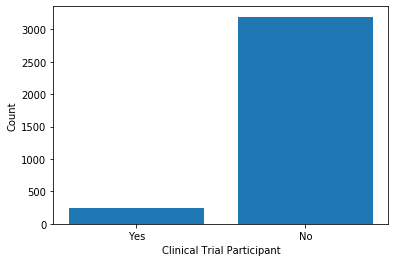

No     3196
Yes     250
Name: Clinical Trial Participant, dtype: int64


In [10]:
'''
Visualizing the imbalance in dataset
'''
labels = ["Yes", "No"]
sizes=[]
for res in labels:
    sizes.append(patdf[patdf["Clinical Trial Participant"]==res].shape[0])
plt.xlabel("Clinical Trial Participant")
plt.ylabel("Count")
plt.bar(labels,sizes)
plt.show()
print(patdf["Clinical Trial Participant"].value_counts())

In [11]:
'''
Splitting data into train-test sets.
Note: Important to split train/test data before resampling
'''
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

y = patdf[["Clinical Trial Participant"]]
y["Clinical Trial Participant"] = y["Clinical Trial Participant"].astype("category")
print(y["Clinical Trial Participant"].value_counts())


#Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


No     3196
Yes     250
Name: Clinical Trial Participant, dtype: int64


In [12]:
"""
Dealing with imbalanced data: 
Random oversampling of minority class, i.e CTP = "Yes"
"""
from sklearn.utils import resample

#Concatenate training data 
X = pd.concat([X_train, y_train], axis=1)

#Separate majority & minority classes
no_CTP = X[X["Clinical Trial Participant"]=="No"]
yes_CTP = X[X["Clinical Trial Participant"]=="Yes"]

print(no_CTP.shape)
print(yes_CTP.shape)

#Upsample minority class
CTP_upsampled = resample(yes_CTP,
                         replace=True, #Sample with replacement
                         n_samples= (len(no_CTP)), #Match the majority class
                         random_state=100)

#Concatenate majority and upsampled minority
upsampled = pd.concat([no_CTP, CTP_upsampled])

print(upsampled["Clinical Trial Participant"].value_counts())

(2557, 23)
(199, 23)
Yes    2557
No     2557
Name: Clinical Trial Participant, dtype: int64


### Classification using Random Forests

Accuracy: 0.8840579710144928
Recall:  0.1568627450980392
Precision: 0.17777777777777778
F1 Score: 0.16666666666666666


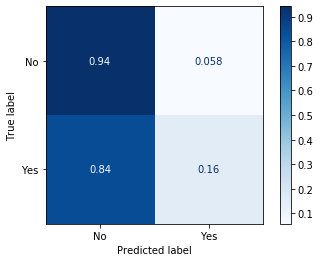

In [13]:
"""
Classification using RandomForestClassifier
"""
from sklearn.ensemble import RandomForestClassifier

y_train = upsampled["Clinical Trial Participant"]
X_train = upsampled.drop('Clinical Trial Participant', axis=1)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)


'''
Look at different metrics to evaluate model
'''
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred, pos_label = "Yes"))
print("Precision:", metrics.precision_score(y_test,y_pred, pos_label = 'Yes'))
print("F1 Score:",metrics.f1_score(y_test,y_pred, pos_label="Yes"))
metrics.confusion_matrix(y_test,y_pred, labels=["Yes", "No"])


'''
Confusion Matrix
'''
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')


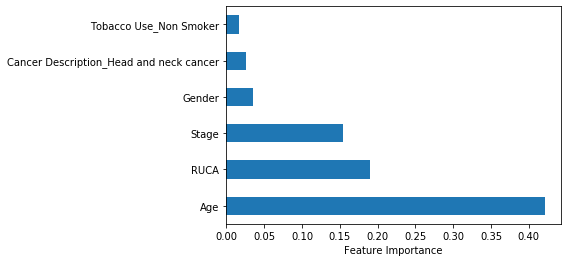

In [14]:
'''
Plotting Feature Importances
'''
feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.xlabel("Feature Importance")
feature_imp.nlargest(6).plot(kind='barh')


### Classification using SVM

Accuracy: 0.6884057971014492
Recall:  0.47058823529411764
Precision: 0.11320754716981132


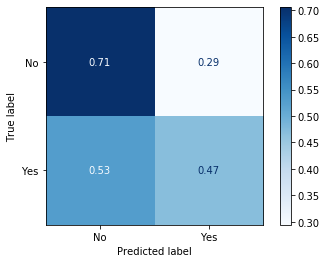

In [15]:
"""
Classification using SVM
"""

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifier=SVC(kernel ='linear', C=1, gamma=1, probability=True)
classifier.fit(X_train, y_train)
y_pred= classifier.predict(X_test)


'''
Look at different metrics to evaluate model
'''
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred, pos_label = "Yes"))
print("Precision:", metrics.precision_score(y_test,y_pred, pos_label = 'Yes'))
metrics.confusion_matrix(y_test,y_pred, labels=["Yes", "No"])

'''
Confusion Matrix
'''
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues, normalize='true')


### Classification using Logistic Regression

Accuracy: 0.6144927536231884
Recall:  0.5098039215686274
Precision: 0.09737827715355805
F1 Score: 0.16352201257861637


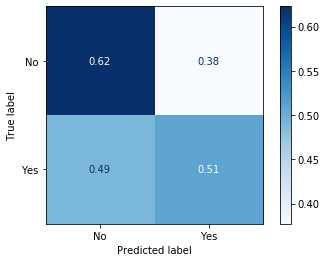

In [16]:
"""
Classification using Logistic Regression
"""

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(max_iter=400)
res = logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)


"""
Different metrics to evaluate classifiers
"""
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred, pos_label = "Yes"))
print("Precision:", metrics.precision_score(y_test,y_pred, pos_label = 'Yes'))
print("F1 Score:",metrics.f1_score(y_test,y_pred, pos_label="Yes"))

"""
Confusion Matrix
"""
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logisticRegr, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

### Plotting ROC curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.602
Random Forest: ROC AUC=0.608
SVM: ROC AUC=0.606


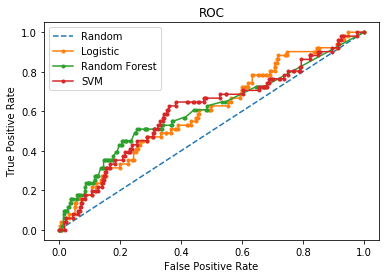

In [17]:
"""
Plotting ROC curve for logistic regression
Reference: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
"""
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = logisticRegr.predict_proba(X_test)
rf_probs = clf.predict_proba(X_test)
svm_probs = classifier.predict_proba(X_test)

#keep probabilities for the positive ("Yes") outcome only
lr_probs = lr_probs[:, 1]
rf_probs = rf_probs[:, 1]
svm_probs = svm_probs[:, 1]


# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
svm_auc = roc_auc_score(y_test, svm_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label="Yes")
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs, pos_label = "Yes")
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs, pos_label = "Yes")
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs, pos_label = "Yes")


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')

# axis labels
plt.title("ROC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Frequent Itemset Mining

In [18]:
"""
Split data into 2 subsets:
One that has Records with CTP=Yes and the other with CTP=No.
Maximal frequent itemset mining on each of them.
Reference: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpmax/
This code box outputs the result on the data subset with CTP=Yes
"""
from mlxtend.preprocessing import TransactionEncoder
yes_CTP = patdf[patdf["Clinical Trial Participant"] == "Yes"]
datalist = []
record = []
for index, row in yes_CTP.iterrows():
    for col in range(row.size):
        record.append(str(row[col]))
    datalist.append(record)
    record=[]
    
te = TransactionEncoder()
te_ary = te.fit(datalist).transform(datalist)
newdf = pd.DataFrame(te_ary, columns=te.columns_)

from mlxtend.frequent_patterns import fpmax
frequnetitemsets = fpmax(newdf, min_support=0.40, use_colnames=True)

display(frequnetitemsets.head())


,support,itemsets
0,0.420,"(White or Caucasian, Yes, Unknown)"
1,0.440,"(White or Caucasian, Yes, Non Smoker)"
2,0.476,"(White or Caucasian, Yes, Female)"
3,0.524,"(White or Caucasian, Male, Yes)"
4,0.552,"(White or Caucasian, Former Smoker, Yes)"


In [19]:
"""
This code box outputs the result on the data subset with CTP=No
"""
no_CTP = patdf[patdf["Clinical Trial Participant"] == "No"]
datalist = []
record = []
for index, row in no_CTP.iterrows():
    for col in range(row.size):
        record.append(str(row[col]))
    datalist.append(record)
    record=[]
        
te = TransactionEncoder()
te_ary = te.fit(datalist).transform(datalist)
newdf = pd.DataFrame(te_ary, columns=te.columns_)

frequnetitemsets = fpmax(newdf, min_support=0.40, use_colnames=True)
display(frequnetitemsets.head())

,support,itemsets
0,0.467146,"(White or Caucasian, Male, No)"
1,0.532854,"(White or Caucasian, No, Female)"
2,0.604193,"(White or Caucasian, No, Former Smoker)"
